## Load Model and Sample Data

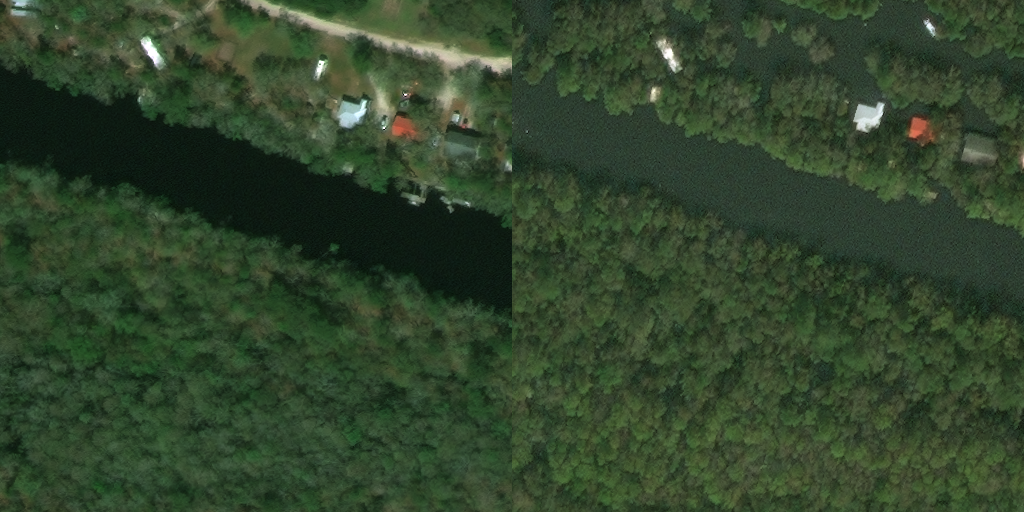

In [1]:
from PIL import Image
from diffusers.utils import make_image_grid
import rasterio
import numpy as np


def tif_to_pil(tif_path):
    # Open the TIFF file and read the RGB bands
    src = rasterio.open(tif_path)
    red, green, blue = src.read((1, 2, 3))

    # Stack the bands and normalize to 8-bit
    rgb = np.dstack((red, green, blue))
    rgb = (rgb * 255 / rgb.max()).astype("uint8")

    # Convert the NumPy array to a PIL Image
    return Image.fromarray(rgb)


filename = "hurricane-florence_00000109"
# filename="guatemala-volcano_00000004"

# pre_image_filepath = f"../data/geotiffs/hold/images/{filename}_pre_disaster.tif"
# post_image_filepath = f"../data/geotiffs/hold/images/{filename}_post_disaster.tif"
# pre_image = tif_to_pil(pre_image_filepath)
# post_image = tif_to_pil(post_image_filepath)

pre_image = Image.open("../data/sample-data/hurricane-florence_00000109_pre_disaster_part1.png")
post_image = Image.open("../data/sample-data/hurricane-florence_00000109_post_disaster_part1.png")


# pre_image.save(f"../sample-data/{filename}_pre_disaster.png")
# post_image.save("../sample-data/{filename}_post_disaster.png")


display(make_image_grid([pre_image, post_image], cols=2, rows=1))

In [3]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

qwen2vl_path = "../models/Qwen/Qwen2-VL-7B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    qwen2vl_path, torch_dtype=torch.bfloat16
).to("cuda")
processor = AutoProcessor.from_pretrained(qwen2vl_path)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
messages_to_post = [
    {
        "role": "user",
        "content": [
            # {"type": "text", "text": "Give change description between two satellite images.\nFocusing on the following objects if present: roads, vehicles, river, buildings, trees, grass and cropland.\nOutput answer with a few sentences in JSON format with key as `caption`."},
            {
                "type": "text",
                "text": "Give change description between two satellite images.\nOutput answer in news style with a few sentences using precise phrases separated by commas",
            },
            {"type": "image", "image": pre_image},
            {"type": "image", "image": post_image},
        ],
    }
]

for messages in [messages_to_post]:
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(
        text=[text], images=image_inputs, padding=True, return_tensors="pt"
    ).to("cuda", torch.bfloat16)
    # Generate captions for the input image pair
    generated_ids = model.generate(
        **inputs, max_new_tokens=512, temperature=0.00001
    )
    generated_ids_trimmed = [
        out_ids[len(in_ids) :]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    captions = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )
    # display(make_image_grid([pre_image,post_image],cols=2,rows=1))
    print(captions[0])

The satellite image shows a noticeable reduction in the number of visible structures along the riverbank, indicating possible demolition or relocation of buildings. The overall greenery appears unchanged, suggesting no significant vegetation loss or growth.


## CFG Generation